<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/PVT/eclipseFluidCharNeqSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Python packages read Eclipse file and import Python libraries

In [1]:
%%capture
! apt update -q
! apt-get install -q openjdk-25-jdk-headless -q
!pip install neqsim -q
import neqsim
!pip install wget
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/examplefile.txt
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/example2.txt
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

#Create original reservoir fluid composition

##Read fluid from Eclipse 300 file

In [2]:
file1 = open('example2.txt', "r")
FileContent = file1.read()
print(FileContent)

﻿-- Dummy EOS for FluidMagic Test case
-- 
-- Copyright (C) 2022 Equinor 


-- Units
METRIC
-- Number of components:
NCOMPS
22 /
-- Equation of state
EOS
PR /
PRCORR


-- Reservoir temperature (C)
RTEMP
     90.00 /


-- Standard Conditions (C and bara)
STCOND
   15.00000    1.01325  /


-- Component names
CNAMES
N2
CO2
C1
C2
C3
iC4
C4
iC5
C5
C6
C7
C8
C9
C10-C12
C13-C14
C15-C17
C18-C21
C22-C28
C29-C36
C37-C45
C46-C58
C59-C80 /
-- Tc (K)
TCRIT
   126.200
   304.200
   190.600
   305.400
   369.800
   408.100
   425.200
   460.400
   469.600
   507.400
   548.083
   568.470
   592.686
   631.845
   680.299
   727.035
   774.284
   851.846
   943.373
  1038.592
  1152.236
  1317.304 /
-- Pc (Bar)
PCRIT
   33.9439
   73.7646
   46.0015
   48.8387
   42.4552
   36.4770
   37.9969
   33.8426
   33.7412
   29.6882
   29.4519
   27.6423
   25.5535
   22.7296
   20.0143
   18.1224
   16.7108
   15.1759
   14.0297
   13.2891
   12.7370
   12.2645 /
-- Omega
ACF
   0.04000
   0.22500
   0.00800
 

##Create NeqSim fluid from Eclipse file
Run TP flash at reservoir temperature and pressure

In [3]:
fluid1 = readEclipseFluid('example2.txt')
fluid1.addComponent('water')
fluid1.setMixingRule('classic')

reservoirPressure = 100
fluid1.setPressure(reservoirPressure, 'bara')
reservoirTemperature = 90.0 # C
fluid1.setTemperature(reservoirTemperature, 'C')

satpres = bubp(fluid1)
TPflash(fluid1)


print('saturation pressure at 90C ', fluid1.getPressure('bara'), ' bara')

printFrame(fluid1)

fluid1.setPressure(fluid1.getPressure()-2.0)
TPflash(fluid1)
printFrame(fluid1)

saturation pressure at 90C  198.23302159509677  bara
| 0                    | 1          | 2                  | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:-------------------|:----|:----|:----|:----------------|
|                      | total      | OIL                |     |     |     |                 |
| nitrogen             | 3.912E-3   | 3.912E-3           |     |     |     | [mole fraction] |
| CO2                  | 3.01E-3    | 3.01E-3            |     |     |     | [mole fraction] |
| methane              | 4.03275E-1 | 4.03275E-1         |     |     |     | [mole fraction] |
| ethane               | 7.6341E-2  | 7.6341E-2          |     |     |     | [mole fraction] |
| propane              | 7.9752E-2  | 7.9752E-2          |     |     |     | [mole fraction] |
| i-butane             | 1.1938E-2  | 1.1938E-2          |     |     |     | [mole fraction] |
| n-butane             | 4.0929E-2  | 4.0929E-2          |     |     |     | [mole fraction]

#Step 1 - Generate true well compositions - Run reservoir simulations in NeqSim

##Set up reservoir simulation

We run a reservoir simulation for 10 years

| 0                    | 1          | 2                  | 3                  | 4   | 5   | 6               |
|:---------------------|:-----------|:-------------------|:-------------------|:----|:----|:----------------|
|                      | total      | GAS                | OIL                |     |     |                 |
| nitrogen             | 3.912E-3   | 1.26164E-2         | 3.84813E-3         |     |     | [mole fraction] |
| CO2                  | 3.01E-3    | 4.11266E-3         | 3.00191E-3         |     |     | [mole fraction] |
| methane              | 4.03275E-1 | 7.78161E-1         | 4.00524E-1         |     |     | [mole fraction] |
| ethane               | 7.6341E-2  | 8.11154E-2         | 7.6306E-2          |     |     | [mole fraction] |
| propane              | 7.9752E-2  | 5.71736E-2         | 7.99177E-2         |     |     | [mole fraction] |
| i-butane             | 1.1938E-2  | 6.69751E-3         | 1.19765E-2         |     |     | [mole fraction] |
| n-butane

Text(0, 0.5, 'methane in reservoir oil [mole frac]')

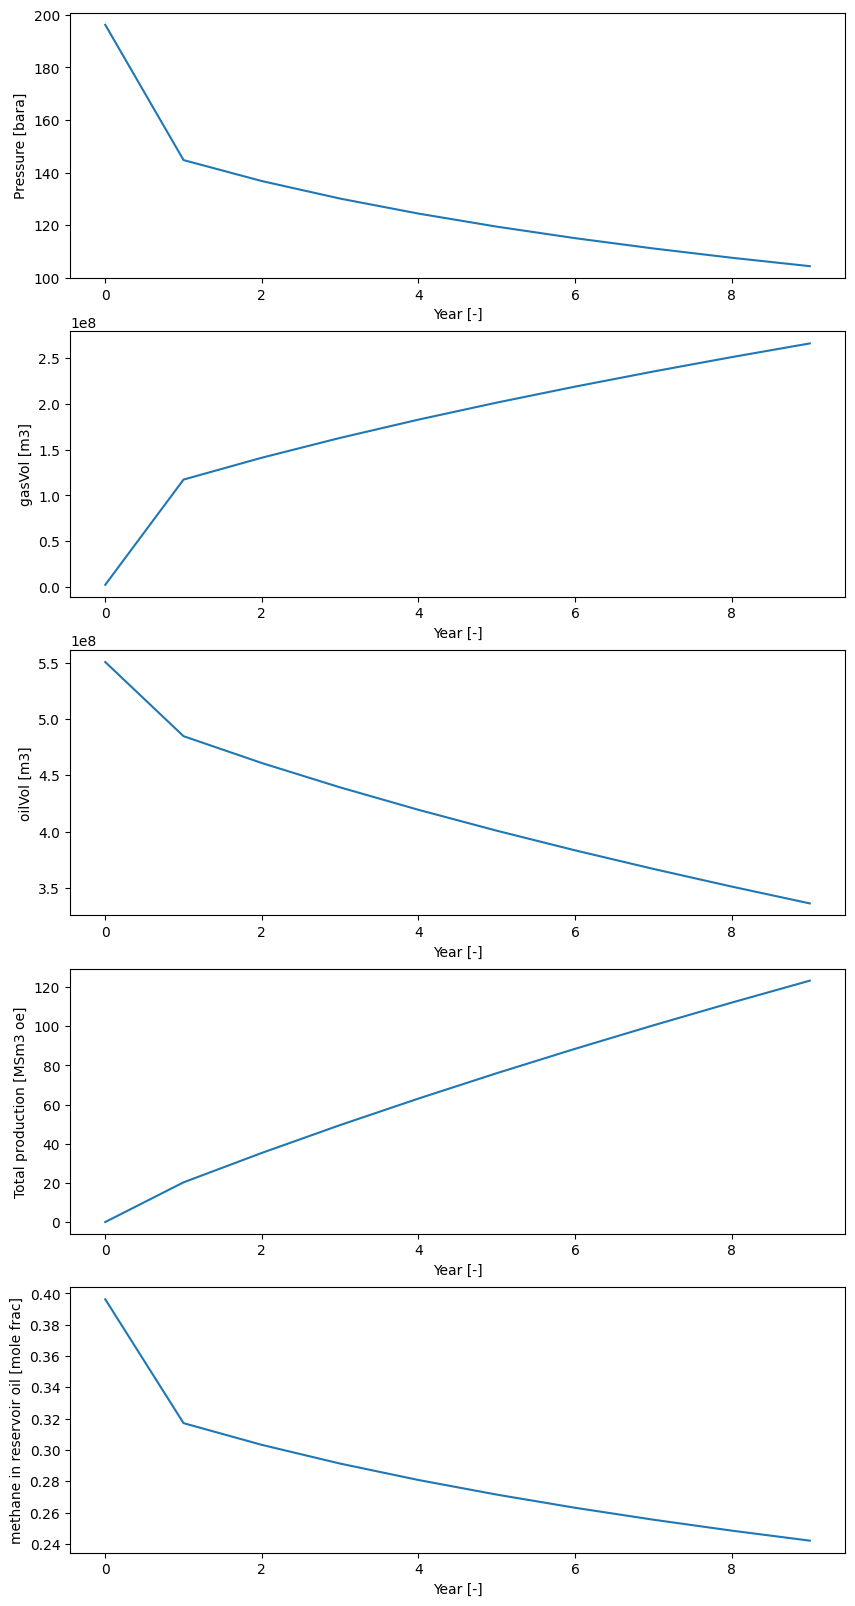

In [4]:
from neqsim.process.processTools import simplereservoir, clearProcess
from neqsim.thermo.thermoTools import *
clearProcess()
resfluid = fluid1.clone()
printFrame(resfluid)
reservoirOps = simplereservoir("Well 1 reservoir", resfluid,  gasvolume=5.0 * 1e7, oilvolume=552.0 * 1e6, watervolume=10.0e3)

producedGasStream = reservoirOps.addGasProducer("SLP_A32562G")
producedGasStream.setFlowRate(0.01, "MSm3/day")

injectionGasStream = reservoirOps.addGasInjector("SLP_A32562GI")
fluidComposition(injectionGasStream.getFluid(), resfluid.getPhase('gas').getMolarComposition())
injectionGasStream.setFlowRate(0.01, "MSm3/day")

producedOilStream = reservoirOps.addOilProducer("SLP_A32562O")
producedOilStream.setFlowRate(50000000.0, "kg/day")


deltat = 24*60*60.0*365
time = []
pressure = []
gasvolume = []
watervolume = []
oilvolume = []
wateringas = []
totalproducedoe = []
C1reservoiroil = []
co2reservoirgas = []
production = []

reservoirOps.run()

for t in range(10):
    time.append(t*deltat/(24*60*60.0*365))
    production.append(producedOilStream.clone())
    pressure.append(reservoirOps.getReservoirFluid().getPressure('bara'))
    gasvolume.append(reservoirOps.getReservoirFluid().getPhase("gas").getVolume("m3"))
    oilvolume.append(reservoirOps.getReservoirFluid().getPhase("oil").getVolume("m3"))
    totalproducedoe.append(reservoirOps.getProductionTotal('MSm3 oe'))
    co2reservoirgas.append(reservoirOps.getReservoirFluid().getComponent('CO2').getz())
    C1reservoiroil.append(reservoirOps.getReservoirFluid().getPhase('oil').getComponent('methane').getx())
    print('gas production ' , reservoirOps.getGasProdution('Sm3/day')/1e6, ' MSm3/day')
    print('oil production ' , reservoirOps.getOilProdution('Sm3/day'), ' Sm3/day')
    print('oil production ' , reservoirOps.getOilProdution('Sm3/day')*6.29, ' bbl/day')
    producedOilStream.setFlowRate(50000000.0*pressure[t]/pressure[0], "kg/day")
    reservoirOps.runTransient(deltat)

plt.rcParams['figure.figsize'] = [10, 20]
#fig, ax = plt.subplots()
plt.subplot(5, 1, 1)
plt.plot(time, pressure)
plt.xlabel('Year [-]')
plt.ylabel('Pressure [bara]')
plt.subplot(5, 1, 2)
plt.plot(time, gasvolume)
plt.xlabel('Year [-]')
plt.ylabel('gasVol [m3]')
plt.subplot(5, 1, 3)
plt.plot(time, oilvolume)
plt.xlabel('Year [-]')
plt.ylabel('oilVol [m3]')
plt.subplot(5, 1, 4)
plt.plot(time, totalproducedoe)
plt.xlabel('Year [-]')
plt.ylabel('Total production [MSm3 oe]')
plt.subplot(5, 1, 5)
plt.plot(time, C1reservoiroil)
plt.xlabel('Year [-]')
plt.ylabel('methane in reservoir oil [mole frac]')


In [5]:
printFrame(production[0].getFluid())
printFrame(production[4].getFluid())

| 0                    | 1          | 2                  | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:-------------------|:----|:----|:----|:----------------|
|                      | total      | OIL                |     |     |     |                 |
| nitrogen             | 3.81981E-3 | 3.81981E-3         |     |     |     | [mole fraction] |
| CO2                  | 2.95948E-3 | 2.95948E-3         |     |     |     | [mole fraction] |
| methane              | 3.96307E-1 | 3.96307E-1         |     |     |     | [mole fraction] |
| ethane               | 7.53028E-2 | 7.53028E-2         |     |     |     | [mole fraction] |
| propane              | 7.88353E-2 | 7.88353E-2         |     |     |     | [mole fraction] |
| i-butane             | 1.18029E-2 | 1.18029E-2         |     |     |     | [mole fraction] |
| n-butane             | 4.0483E-2  | 4.0483E-2          |     |     |     | [mole fraction] |
| i-pentane            | 1.38004E-2 | 1.38004E-2  

#Step 2 -Generate measured test rates (Measure gas and oil volumes at test separator conditions)

We assume 1.01325 bar and 15 C test separator condition

In [6]:
from neqsim.process import *

gasflow = []
oilflow = []
molWg = []

for t in range(10):
  clearProcess()
  wellTP = heater('heater 1', production[t])
  wellTP.setOutTemperature(15.0, 'C')
  wellTP.setOutPressure(1.01325, 'bara')
  wellTP.run()

  sep1 = separator('sep1', wellTP.getOutStream())
  sep1.run()

  gasflow.append(sep1.getGasOutStream().getFlowRate('MSm3/day'))
  oilflow.append(sep1.getLiquidOutStream().getFlowRate('m3/hr'))
  molWg.append(sep1.getGasOutStream().getFluid().getMolarMass())

  print('gas ' , sep1.getGasOutStream().getFlowRate('MSm3/day'), 'MSm3/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('m3/hr')*24, 'm3/day')
  print('gas ' , sep1.getGasOutStream().getFlowRate('kg/day'), 'kg/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('kg/day'), 'kg/day')

gas  8.060259283755238 MSm3/day
oil  48624.53732278531 m3/day
gas  9041050.38295691 kg/day
oil  40958947.60389533 kg/day
gas  7.001172221027898 MSm3/day
oil  58802.22063816109 m3/day
gas  8252961.838291791 kg/day
oil  49445005.107548654 kg/day
gas  4.352279319308519 MSm3/day
oil  38756.47043313709 m3/day
gas  5178632.423528705 kg/day
oil  32576873.762688015 kg/day
gas  3.9177751222982558 MSm3/day
oil  36714.33698037939 m3/day
gas  4699936.0957717905 kg/day
oil  30850007.526456542 kg/day
gas  3.5706246789488247 MSm3/day
oil  35017.43272009182 m3/day
gas  4314758.165255137 kg/day
oil  29415274.225443184 kg/day
gas  3.285169787838709 MSm3/day
oil  33570.10955357668 m3/day
gas  3995875.2871410763 kg/day
oil  28191780.462360144 kg/day
gas  3.0452514776028115 MSm3/day
oil  32311.52904542167 m3/day
gas  3726115.232031836 kg/day
oil  27128053.945402164 kg/day
gas  2.8400944797873726 MSm3/day
oil  31200.586258538096 m3/day
gas  3494003.4971635584 kg/day
oil  26189308.33075867 kg/day
gas  2.6621

# Step 3-5- Topside recombination to match oil and gas rates to calculate the wellstream composition  (Run process simulation with original fluid comp, get composition og gas as sep conditions)

In the following we will use original fluid comp

In [7]:
from neqsim.process import *
import jpype
from jpype.types import *

fluidorg = fluid1.clone()
fluidorg.setPressure(50.0)

gasflow2 = []
oilflow2 = []
molWg2 = []
recombinedfluid = []
for t in range(10):
  clearProcess()
  feedstream = stream('stream1', fluidorg)
  feedstream.run()

  flowset =  jneqsim.process.equipment.util.FlowSetter("flowset", feedstream)
  pressureSep = [1.01325]
  temperatureSep = [15.0]
  flowset.setSeparationPT(JDouble[:](pressureSep), "bara", JDouble[:](temperatureSep), "C");
  flowset.setGasFlowRate(gasflow[t], "MSm3/day")
  flowset.setOilFlowRate(oilflow[t], "m3/hr")
  flowset.run()

  wellTP = heater('heat 1', flowset.getOutStream())
  wellTP.setOutTemperature(15.0, 'C')
  wellTP.setOutPressure(1.01325, 'bara')
  wellTP.run()

  recombinedfluid.append(flowset.getOutStream())

  sep1 = separator('sep1', wellTP.getOutStream())
  sep1.run()

  gasflow2.append(sep1.getGasOutStream().getFlowRate('MSm3/day'))
  oilflow2.append(sep1.getLiquidOutStream().getFlowRate('m3/hr'))
  molWg2.append(sep1.getGasOutStream().getFluid().getMolarMass())

  print('gas ' , sep1.getGasOutStream().getFlowRate('MSm3/day'), 'MSm3/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('m3/hr')*24, 'm3/day')
  print('gas ' , sep1.getGasOutStream().getFlowRate('kg/day'), 'kg/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('kg/day'), 'kg/day')

gas  10.011380941866637 MSm3/day
oil  40210.792179507276 m3/day
gas  10827732.062605593 kg/day
oil  33932989.10984808 kg/day
gas  9.312484775032692 MSm3/day
oil  48837.95268038057 m3/day
gas  10319592.036410438 kg/day
oil  41164889.577672094 kg/day
gas  5.870008087146662 MSm3/day
oil  32213.608562245434 m3/day
gas  6534018.542402156 kg/day
oil  27146798.484885655 kg/day
gas  5.350860537101246 MSm3/day
oil  30536.499569097214 m3/day
gas  5979677.156485069 kg/day
oil  25728820.323396303 kg/day
gas  4.933510005927756 MSm3/day
oil  29142.30394789546 m3/day
gas  5532814.854406864 kg/day
oil  24550178.17620904 kg/day
gas  4.588293901211978 MSm3/day
oil  27952.653424740798 m3/day
gas  5162241.596167629 kg/day
oil  23544571.915581368 kg/day
gas  4.296503771699276 MSm3/day
oil  26917.71084402503 m3/day
gas  4848267.659584437 kg/day
oil  22669836.53699868 kg/day
gas  4.0456410168389265 MSm3/day
oil  26003.80737469458 m3/day
gas  4577725.101207429 kg/day
oil  21897485.55522004 kg/day
gas  3.82697

Comparing true molecular weights of gas from test separator to recombined moler weights

[0.026521986304155396, 0.027872456445903252, 0.02813419517913675, 0.028365380801885293, 0.028572512173689956, 0.028760092240016775, 0.02893138925117299, 0.02908886104876052, 0.029234408610497795, 0.029369536001757023]
[0.02557288248541687, 0.02620192037167798, 0.026319511995027446, 0.02642349585548047, 0.02651711632172464, 0.026602549916942164, 0.026681335273584583, 0.026754604468036892, 0.026823217206891577, 0.02688784333568304]


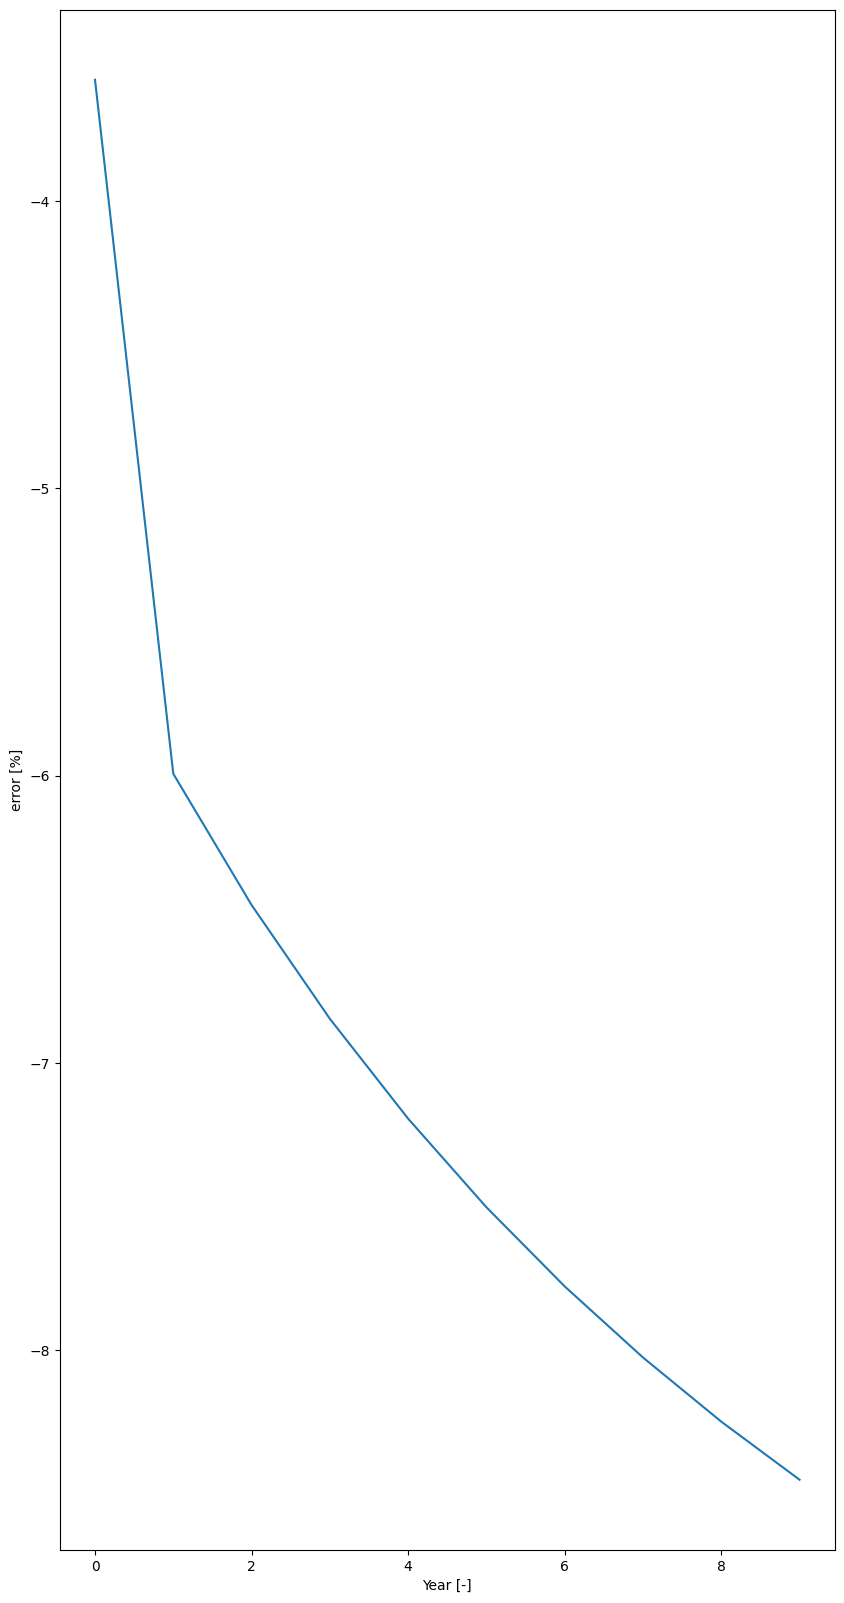

In [8]:
error = []
for t in range(10):
  calc = (molWg2[t]-molWg[t])/molWg[t]*100
  error.append(calc)
print(molWg)
print(molWg2)
plt.plot(time, error)
plt.xlabel('Year [-]')
plt.ylabel('error [%]')
plt.show()

We observe that error in gas molecular weight increase with time. Calculated gas is lighther that real, because gas has been stripped off in reservoir during depletion.

We then compare methane in reservoir fluid from true to recombined of reservoir fluid

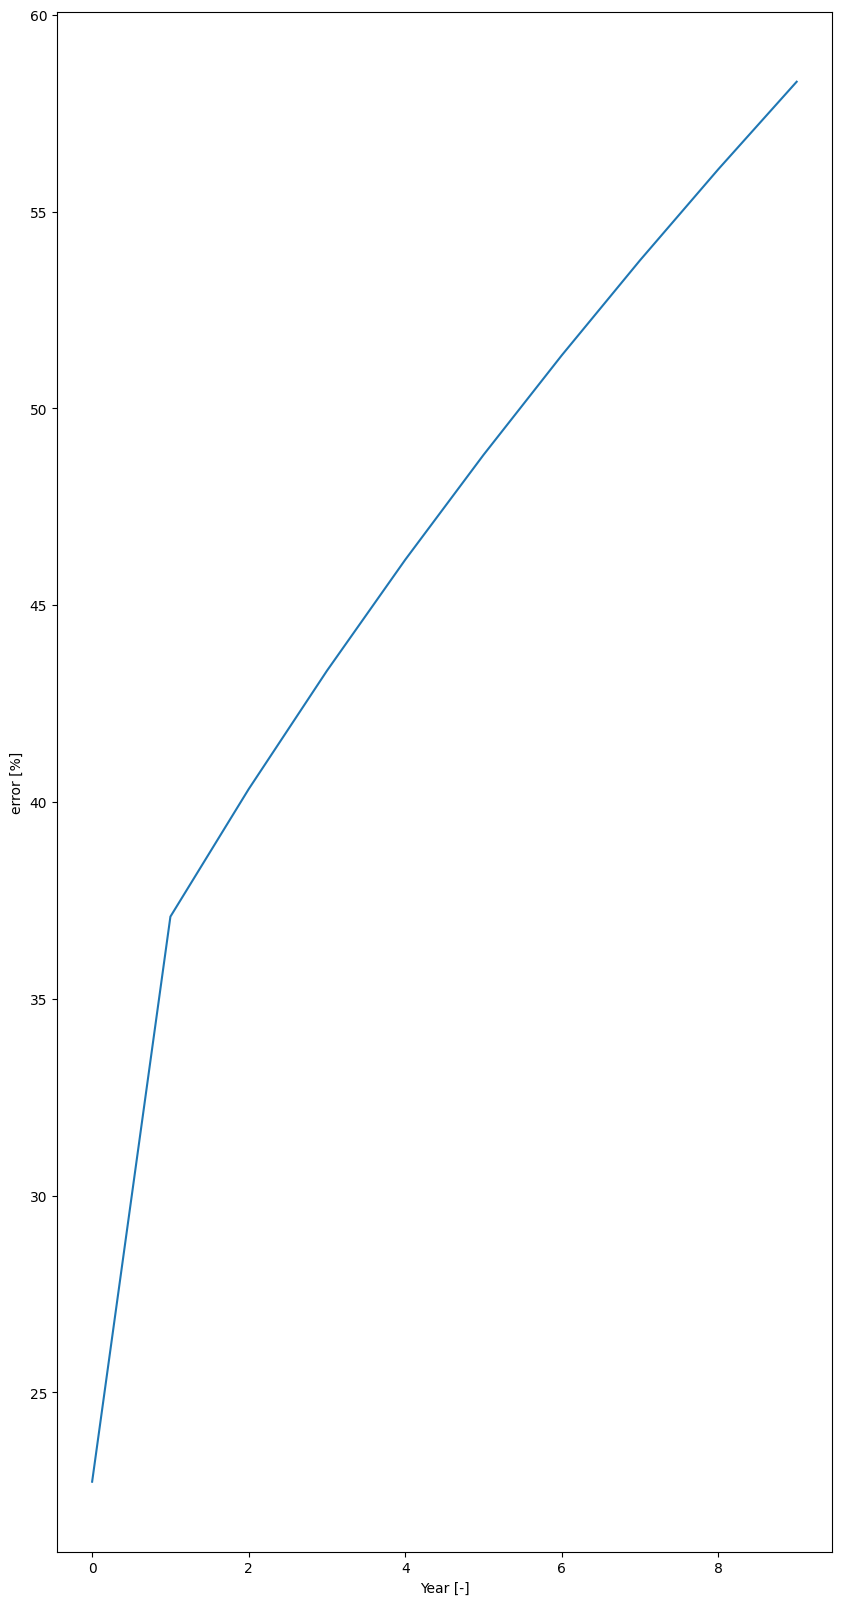

In [9]:
error = []
name = 'methane'
for t in range(10):
  calc = (recombinedfluid[t].getFluid().getComponent(name).getz() - production[t].getFluid().getComponent(name).getz())/production[t].getFluid().getComponent(name).getz()*100
  error.append(calc)

plt.plot(time, error)
plt.xlabel('Year [-]')
plt.ylabel('error [%]')
plt.show()

We see that methane will start to deviate

#Step 6. Improving by running CME of original reservoir fluid

In [10]:
gasflow3 = []
oilflow3 = []
molWg3 = []
recombinedfluid2 = []

for t in range(10):
  clearProcess()
  fluidorg = fluid1.clone()
  fluidorg.setPressure(pressure[t])
  TPflash(fluidorg)
  feedstream = stream('stream1', fluidorg.phaseToSystem('oil'))
  feedstream.run()

  flowset =  jneqsim.process.equipment.util.FlowSetter("flowset", feedstream)
  pressureSep = [1.01325]
  temperatureSep = [15.0]
  flowset.setSeparationPT(JDouble[:](pressureSep), "bara", JDouble[:](temperatureSep), "C");
  flowset.setGasFlowRate(gasflow[t], "MSm3/day")
  flowset.setOilFlowRate(oilflow[t], "m3/hr")
  flowset.run()
  recombinedfluid2.append(flowset.getOutStream())

  wellTP = heater('heat1',flowset.getOutStream())
  wellTP.setOutTemperature(15.0, 'C')
  wellTP.setOutPressure(1.01325, 'bara')
  wellTP.run()

  sep1 = separator('sep1', wellTP.getOutStream())
  sep1.run()

  gasflow3.append(sep1.getGasOutStream().getFlowRate('MSm3/day'))
  oilflow3.append(sep1.getLiquidOutStream().getFlowRate('m3/hr'))
  molWg3.append(sep1.getGasOutStream().getFluid().getMolarMass())

  print('gas ' , sep1.getGasOutStream().getFlowRate('MSm3/day'), 'MSm3/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('m3/hr')*24, 'm3/day')
  print('gas ' , sep1.getGasOutStream().getFlowRate('kg/day'), 'kg/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('kg/day'), 'kg/day')

gas  6.840386525672967 MSm3/day
oil  42321.0252579295 m3/day
gas  7711566.73900542 kg/day
oil  35644966.75502008 kg/day
gas  6.135421541417041 MSm3/day
oil  53074.068180876624 m3/day
gas  7279384.85858148 kg/day
oil  44622273.69710508 kg/day
gas  3.8304987807486572 MSm3/day
oil  35160.078761614015 m3/day
gas  4588646.082708158 kg/day
oil  29549782.531198665 kg/day
gas  3.460092138898826 MSm3/day
oil  33446.31795559256 m3/day
gas  4180022.123192521 kg/day
oil  28100014.814569216 kg/day
gas  3.162676111117073 MSm3/day
oil  32011.74620246978 m3/day
gas  3849505.9814695003 kg/day
oil  26886638.141052034 kg/day
gas  2.9171034990665548 MSm3/day
oil  30780.02882961798 m3/day
gas  3574689.91694261 kg/day
oil  25845059.33232369 kg/day
gas  2.709989973126559 MSm3/day
oil  29702.50803808283 m3/day
gas  3341369.9905011375 kg/day
oil  24934086.625062272 kg/day
gas  2.5323689225940127 MSm3/day
oil  28746.21234771469 m3/day
gas  3140010.568945933 kg/day
oil  24125798.33827479 kg/day
gas  2.3779649714

[0.026521986304155396, 0.027872456445903252, 0.02813419517913675, 0.028365380801885293, 0.028572512173689956, 0.028760092240016775, 0.02893138925117299, 0.02908886104876052, 0.029234408610497795, 0.029369536001757023]
[0.026656194472229763, 0.028053460689072537, 0.028324705520284134, 0.02856453022739766, 0.02877971242865067, 0.02897495076124192, 0.02915365790035756, 0.0293184025934588, 0.02947117384467512, 0.029613547601201384]


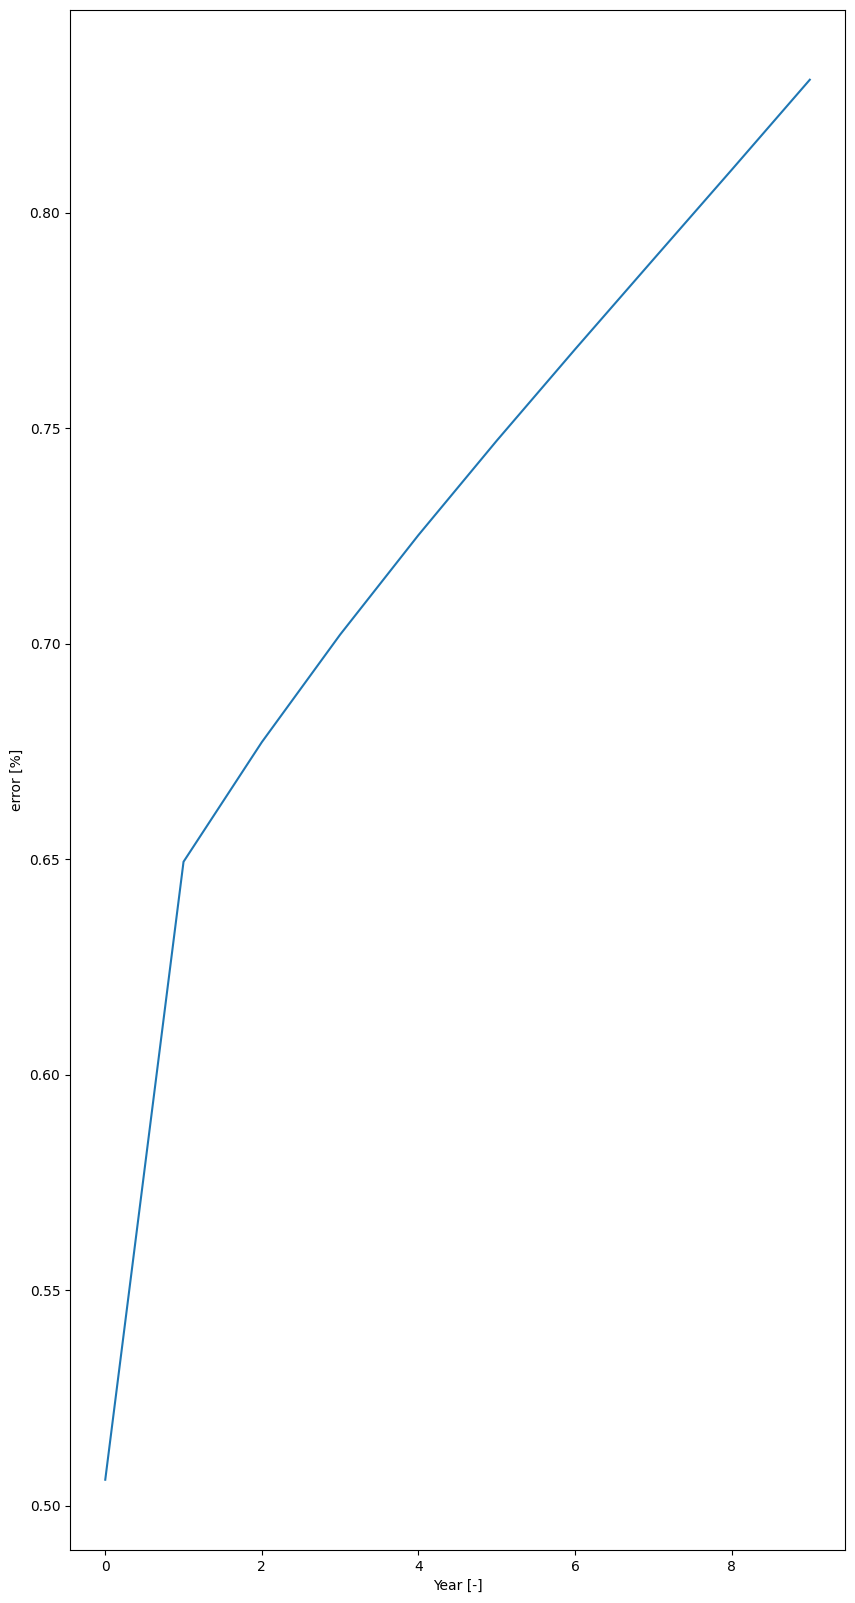

In [11]:
error = []
for t in range(10):
  calc = (molWg3[t]-molWg[t])/molWg[t]*100
  error.append(calc)
print(molWg)
print(molWg3)
plt.plot(time, error)
plt.xlabel('Year [-]')
plt.ylabel('error [%]')
plt.show()

We see a significant imporvment in molecular weight calculation.

We then compare methan in reservoir fluid.

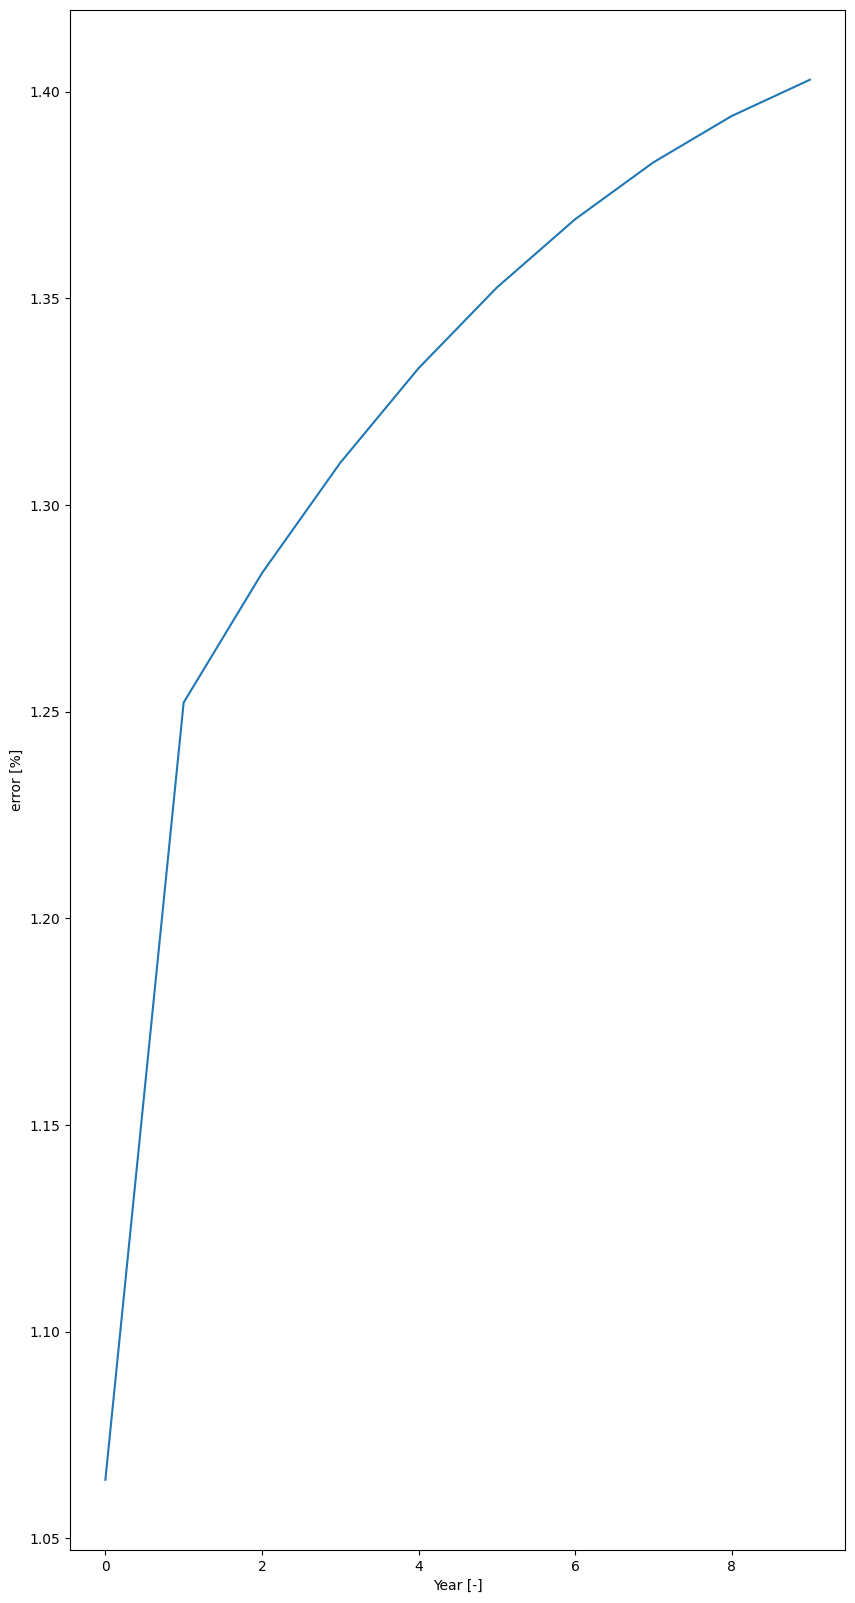

In [12]:
error = []
name = 'methane'
for t in range(10):
  calc = (recombinedfluid2[t].getFluid().getComponent(name).getz() - production[t].getFluid().getComponent(name).getz())/production[t].getFluid().getComponent(name).getz()*100
  error.append(calc)

plt.plot(time, error)
plt.xlabel('Year [-]')
plt.ylabel('error [%]')
plt.show()

We see that results have improved considerably for reservoir fluid composition.

We see that be running a CME the results improve a lot.

#Step 7. Run process simulation with corrected fluid composition and real compositon

##Case 1: first we run with real composition (from reservoir simulation)

In [13]:
#select year
year = 0

In [14]:
inputdata = {
  'topsidePressure': 90.0,
  'topsideTemperature': 86.16,
  'temperatureOilHeater' : 60.0,
  'temperatureOilHeater2' : 91.0,
  'secondStagePressure': 22.4,
  'thirdStagePressure': 5.7,
  'fourthStagePressure': 1.96,
  'firstStageSuctionCoolerTemperature': 45.0,
  'secondStageSuctionCoolerTemperature': 40.0,
  'thirdStageSuctionCoolerTemperature':35,
  'dewPointSuctionCoolerTemperature':35,
  'firstStageExportCoolerTemperature': 35,
  'secondStageExportCoolerTemperature': 35,
  'thirdStageExportCoolerTemperature': 35,
  'firststageexportpressure': 250.0,
  'secondstageexportpressure': 474.0,
  'thirdstageexportpressure': 633.0,
}

In [15]:
from neqsim.thermo import fluid, printFrame
from neqsim.process import compsplitter, compressor, splitter, cooler, separator3phase, getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle, setpoint, calculator


fluidinp = production[year].getFluid().clone()
fluidinp.addComponent('water', 100.0)
fluidinp.setMixingRule(2)
fluidinp.setMultiPhaseCheck(True)
fluidinp.setPressure(inputdata['topsidePressure'], 'bara')
fluidinp.setTemperature(50.0, 'C')
TPflash(fluidinp)

clearProcess()

wellFluid = stream('stream1', fluidinp)
wellFluid.setPressure(inputdata['topsidePressure'], "bara")
wellFluid.run()

feedTPsetter = heater('heat1', wellFluid)
feedTPsetter.setName('inletTP')
feedTPsetter.setOutPressure(inputdata['topsidePressure'], "bara")
feedTPsetter.setOutTemperature(inputdata['topsideTemperature'], "C")

feedToOffshoreProcess = stream('stream2', feedTPsetter.getOutStream())
feedToOffshoreProcess.setName("feed to offshore")

firstStageSeparator = separator3phase('sepin', feedToOffshoreProcess)
firstStageSeparator.setName("1st stage separator")

oilThrotValve = valve('vlv1', firstStageSeparator.getOilOutStream())
oilThrotValve.setName("valve oil from first stage")
oilThrotValve.setOutletPressure(inputdata['secondStagePressure'])

oilThirdStageToMix2 =  stream('str1', wellFluid.clone())
oilThirdStageToMix2.setName("resyc oil to mixer 2")

HPMixer = mixer("HP oil mixer")
HPMixer.addStream(oilThrotValve.getOutStream())
HPMixer.addStream(oilThirdStageToMix2)

oilHeaterFromFirstStage = heater('ht1', HPMixer.getOutStream())
oilHeaterFromFirstStage.setName("oil heater second stage")
oilHeaterFromFirstStage.setOutTemperature(inputdata['temperatureOilHeater'],'C')

secondStageSeparator = separator3phase('secondStageSeparator', oilHeaterFromFirstStage.getOutStream())
secondStageSeparator.addStream(oilThirdStageToMix2)
secondStageSeparator.setName("2nd stage separator")

oilHeaterFromSecondStage = heater('ht2', secondStageSeparator.getOilOutStream())
oilHeaterFromSecondStage.setName("oil heater third stage")
oilHeaterFromSecondStage.setOutTemperature(inputdata['temperatureOilHeater2'],'C')

oilThrotValve2 = valve('oilv2', oilHeaterFromSecondStage.getOutStream())
oilThrotValve2.setOutletPressure(inputdata['thirdStagePressure'])

thirdStageSeparator = separator3phase('seep', oilThrotValve2.getOutStream())
thirdStageSeparator.setName("3rd stage separator")

oilThirdStageToSep =  stream('strr', wellFluid.clone())
oilThirdStageToSep.setName("resyc oil")
thirdStageSeparator.addStream(oilThirdStageToSep)

oilThrotValve3 = valve('vlv3', thirdStageSeparator.getOilOutStream())
oilThrotValve3.setName("valve oil from third stage")
oilThrotValve3.setOutletPressure(inputdata['fourthStagePressure'])

fourthStageSeparator = separator3phase('sep5', oilThrotValve3.getOutStream())
fourthStageSeparator.setName("4th stage separator")

stableOil = stream('stroil', fourthStageSeparator.getOilOutStream())
stableOil.setName("stable oil")

stableOilPump = pump('pupmp', stableOil,15.0)

firstStageCooler = cooler('cool1', fourthStageSeparator.getGasOutStream())
firstStageCooler.setName("1st stage cooler")
firstStageCooler.setOutTemperature(inputdata['firstStageSuctionCoolerTemperature'],'C')

firstStageScrubber = separator('se11', firstStageCooler.getOutStream())
firstStageScrubber.setName("1st stage scrubber")

firstStageCompressor = compressor('comp1', firstStageScrubber.getGasOutStream())
firstStageCompressor.setName("1st stage compressor")
firstStageCompressor.setOutletPressure(inputdata['thirdStagePressure'])
firstStageCompressor.setIsentropicEfficiency(0.75)

secondstageGasMixer = mixer("seccond Stage mixer")
secondstageGasMixer.addStream(firstStageCompressor.getOutStream())
secondstageGasMixer.addStream(thirdStageSeparator.getGasOutStream())

secondStageCooler = cooler('cool22', secondstageGasMixer.getOutStream())
secondStageCooler.setName("2nd stage cooler")
secondStageCooler.setOutTemperature(inputdata['secondStageSuctionCoolerTemperature'],'C')

secondStageScrubber = separator('seee', secondStageCooler.getOutStream())
secondStageScrubber.setName("2nd stage scrubber")

secondStageCompressor = compressor('comp2', secondStageScrubber.getGasOutStream())
secondStageCompressor.setName("2nd stage compressor")
secondStageCompressor.setOutletPressure(inputdata['secondStagePressure'])
secondStageCompressor.setIsentropicEfficiency(0.75)

thirdstageGasMixer = mixer("third Stage mixer")
thirdstageGasMixer.addStream(secondStageCompressor.getOutStream())
thirdstageGasMixer.addStream(secondStageSeparator.getGasOutStream())

thirdStageCooler = cooler('cool3', thirdstageGasMixer.getOutStream())
thirdStageCooler.setName("3rd stage cooler")
thirdStageCooler.setOutTemperature(inputdata['thirdStageSuctionCoolerTemperature'],'C')

thirdStageScrubber = separator('third3s', thirdStageCooler.getOutStream())
thirdStageScrubber.setName("3rd stage scrubber")

thirdStageCompressor = compressor('comp3', thirdStageScrubber.getGasOutStream())
thirdStageCompressor.setName("3rd stage compressor")
thirdStageCompressor.setOutletPressure(inputdata['topsidePressure'])
thirdStageCompressor.setIsentropicEfficiency(0.75)

richGasMixer = mixer("fourth Stage mixer")
richGasMixer.addStream(thirdStageCompressor.getOutStream())
richGasMixer.addStream(firstStageSeparator.getGasOutStream())

dewPointControlCooler = cooler('cool7', richGasMixer.getOutStream())
dewPointControlCooler.setName("dew point cooler")
dewPointControlCooler.setOutTemperature(inputdata['dewPointSuctionCoolerTemperature'],'C')

dewPointScrubber = separator('seeep', dewPointControlCooler.getOutStream())
dewPointScrubber.setName("dew point scrubber")

lpLiqmixer = mixer("LP liq mixer");
lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(thirdStageScrubber.getLiquidOutStream());

hpResycle = recycle("HP liq resycle")
hpResycle.addStream(dewPointScrubber.getLiquidOutStream())
hpResycle.setOutletStream(oilThirdStageToMix2)

lpResycle = recycle("LP liq resycle")
lpResycle.addStream(lpLiqmixer.getOutStream())
lpResycle.setOutletStream(oilThirdStageToSep)

exportCompressor1 = compressor('compp', dewPointScrubber.getGasOutStream())
exportCompressor1.setName("export 1st stage")
exportCompressor1.setOutletPressure(inputdata['firststageexportpressure'])
exportCompressor1.setIsentropicEfficiency(0.75)

exportCooler = cooler('exp cool', exportCompressor1.getOutStream())
exportCooler.setName("export cooler")
exportCooler.setOutTemperature(inputdata['secondStageExportCoolerTemperature'],'C')

exportGas = stream('expg', exportCooler.getOutStream())
exportGas.setName("export gas")

oilprocess = getProcess()

In [16]:
printFrame(fluidinp)

| 0                    | 1          | 2           | 3           | 4   | 5   | 6               |
|:---------------------|:-----------|:------------|:------------|:----|:----|:----------------|
|                      | total      | OIL         | AQUEOUS     |     |     |                 |
| nitrogen             | 3.76012E-3 | 3.85472E-3  | 3.50702E-8  |     |     | [mole fraction] |
| CO2                  | 2.91323E-3 | 2.98647E-3  | 2.31741E-6  |     |     | [mole fraction] |
| methane              | 3.90114E-1 | 3.99929E-1  | 3.54491E-7  |     |     | [mole fraction] |
| ethane               | 7.41261E-2 | 7.59911E-2  | 2.34816E-10 |     |     | [mole fraction] |
| propane              | 7.76034E-2 | 7.95558E-2  | 2.78384E-12 |     |     | [mole fraction] |
| i-butane             | 1.16184E-2 | 1.19107E-2  | 9.05462E-16 |     |     | [mole fraction] |
| n-butane             | 3.98504E-2 | 4.0853E-2   | 3.58519E-15 |     |     | [mole fraction] |
| i-pentane            | 1.35847E-2 | 1.

In [17]:
#oilprocess.run() #run this to finish thread before continuing
thread = oilprocess.runAsThread()
thread.join(50000) # set maximum time to 50000 msec before continuing

In [18]:
TVP = stableOil.TVP(20.0, 'C')
cricondenbar = exportGas.CCB('bara')
powerComp1 = oilprocess.getUnit("1st stage compressor").getPower()/1.0e3
powerComp2 = oilprocess.getUnit("2nd stage compressor").getPower()/1.0e3
powerComp3 = oilprocess.getUnit("3rd stage compressor").getPower()/1.0e3
powerExpComp1 = oilprocess.getUnit("export 1st stage").getPower()/1.0e3


flowRate = exportGas.getFlowRate('MSm3/day')
flowRateOil = stableOilPump.getOutStream().getFlowRate('kg/hr')
oildensity = stableOilPump.getOutStream().getFluid().getDensity('kg/m3')
oilkbblperday = flowRateOil/oildensity*6.29*24/1e3

print('feed flow [kg/hr] ', feedToOffshoreProcess.getFlowRate('kg/hr')/1e6)
print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('recomp power 1 [kW] ', powerComp1)
print('recomp power 2 [kW] ', powerComp2)
print('recomp power 3 [kW] ', powerComp3)
print('exp power 1 [kW] ', powerExpComp1)
print('gas export [MSm3/d] ', flowRate)
print('oil export [m3/hr] ', flowRateOil/oildensity)
print('oil export [kbbl/day] ', flowRateOil/oildensity*6.29*24/1e3)
print('oil export [10^6*kg/hr] ', flowRateOil/1e6)
print('oil density [kg/m3] ', oildensity)

feed flow [kg/hr]  2.0898187333333333
TVP [bara]  0.9872125883171482
cricondenbar [bara]  104.78809594574103
recomp power 1 [kW]  -1761.3824420100145
recomp power 2 [kW]  20060.905208636294
recomp power 3 [kW]  11021.362676018252
exp power 1 [kW]  10868.879616045568
gas export [MSm3/d]  8.187133243529763
oil export [m3/hr]  2206.070203101441
oil export [kbbl/day]  333.0283578601936
oil export [10^6*kg/hr]  1.7921122161780374
oil density [kg/m3]  812.355025537522


In [19]:
printFrame(exportGas.getFluid())
printFrame(stableOil.getFluid())

| 0                    | 1           | 2           | 3            | 4   | 5   | 6               |
|:---------------------|:------------|:------------|:-------------|:----|:----|:----------------|
|                      | total       | GAS         | AQUEOUS      |     |     |                 |
| nitrogen             | 6.28871E-3  | 6.29054E-3  | 1.16141E-8   |     |     | [mole fraction] |
| CO2                  | 5.13505E-3  | 5.13653E-3  | 2.52805E-6   |     |     | [mole fraction] |
| methane              | 6.70913E-1  | 6.71108E-1  | 1.46438E-7   |     |     | [mole fraction] |
| ethane               | 1.33996E-1  | 1.34034E-1  | 9.14281E-11  |     |     | [mole fraction] |
| propane              | 1.27831E-1  | 1.27868E-1  | 8.15086E-13  |     |     | [mole fraction] |
| i-butane             | 1.26723E-2  | 1.2676E-2   | 1.11551E-16  |     |     | [mole fraction] |
| n-butane             | 3.18701E-2  | 3.18794E-2  | 3.69049E-16  |     |     | [mole fraction] |
| i-pentane         


##Case 2: run topside process simulation with simplified composition (recombined fluid)

In [20]:
fluidinp2 = recombinedfluid[year].getFluid().clone()
fluidinp2.addComponent('water', 100.0)
fluidinp2.setMixingRule(2)
fluidinp2.setMultiPhaseCheck(True)
fluidinp2.setPressure(inputdata['topsidePressure'], 'bara')
fluidinp2.setTemperature(50.0, 'C')
TPflash(fluidinp2)

wellFluid.setFluid(fluidinp2)
wellFluid.setPressure(inputdata['topsidePressure'], "bara")
wellFluid.run()

#oilprocess.run() #run this to finish thread before continuing
thread = oilprocess.runAsThread()
thread.join(50000) # set maximum time to 50000 msec before continuing

TVP = stableOil.TVP(20.0, 'C')
cricondenbar = exportGas.CCB('bara')
powerComp1 = oilprocess.getUnit("1st stage compressor").getPower()/1.0e3
powerComp2 = oilprocess.getUnit("2nd stage compressor").getPower()/1.0e3
powerComp3 = oilprocess.getUnit("3rd stage compressor").getPower()/1.0e3
powerExpComp1 = oilprocess.getUnit("export 1st stage").getPower()/1.0e3


flowRate = exportGas.getFlowRate('MSm3/day')
flowRateOil = stableOilPump.getOutStream().getFlowRate('kg/hr')
oildensity = stableOilPump.getOutStream().getFluid().getDensity('kg/m3')
oilkbblperday = flowRateOil/oildensity*6.29*24/1e3

print('feed flow [kg/hr] ', feedToOffshoreProcess.getFlowRate('kg/hr')/1e6)
print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('recomp power 1 [kW] ', powerComp1)
print('recomp power 2 [kW] ', powerComp2)
print('recomp power 3 [kW] ', powerComp3)
print('exp power 1 [kW] ', powerExpComp1)
print('gas export [MSm3/d] ', flowRate)
print('oil export [m3/hr] ', flowRateOil/oildensity)
print('oil export [kbbl/day] ', flowRateOil/oildensity*6.29*24/1e3)
print('oil export [10^6*kg/hr] ', flowRateOil/1e6)
print('oil density [kg/m3] ', oildensity)

feed flow [kg/hr]  1.8715154488522356
TVP [bara]  0.975323384863421
cricondenbar [bara]  107.41873317963785
recomp power 1 [kW]  -1761.3824420100145
recomp power 2 [kW]  17074.544929423475
recomp power 3 [kW]  8660.545539059636
exp power 1 [kW]  -64854.15829468099
gas export [MSm3/d]  9.988221322802438
oil export [m3/hr]  1847.9945313294052
oil export [kbbl/day]  278.973254449487
oil export [10^6*kg/hr]  1.4995322760186571
oil density [kg/m3]  811.4376155322968


In [21]:
printFrame(exportGas.getFluid())
printFrame(stableOil.getFluid())

| 0                    | 1           | 2           | 3            | 4   | 5   | 6               |
|:---------------------|:------------|:------------|:-------------|:----|:----|:----------------|
|                      | total       | GAS         | AQUEOUS      |     |     |                 |
| nitrogen             | 7.00091E-3  | 7.00302E-3  | 1.24009E-8   |     |     | [mole fraction] |
| CO2                  | 5.10839E-3  | 5.10993E-3  | 2.51292E-6   |     |     | [mole fraction] |
| methane              | 7.04795E-1  | 7.05007E-1  | 1.51453E-7   |     |     | [mole fraction] |
| ethane               | 1.23992E-1  | 1.24029E-1  | 8.61811E-11  |     |     | [mole fraction] |
| propane              | 1.07941E-1  | 1.07973E-1  | 7.1788E-13   |     |     | [mole fraction] |
| i-butane             | 1.08019E-2  | 1.08051E-2  | 1.00679E-16  |     |     | [mole fraction] |
| n-butane             | 2.78886E-2  | 2.7897E-2   | 3.4459E-16   |     |     | [mole fraction] |
| i-pentane         

#Create well streams, fit to gas and oil rates from reservoir simulation, mix and separate

In [22]:
from neqsim.process import  mixer, heater, stream, separator, GORfitter

In [23]:
#from eclipse
gas_flow = 1.0 #MSm3/day
oil_flow = 2000.0 #m3/hr
water_flow = 1000.0 #m3/hr
clearProcess()
# Creating Well 1
well1 = stream('str1', fluid1.clone())
molar_composition_well1 = [
    0.003912, 0.003010, 0.303275, 0.076341, 0.079752, 0.011938, 0.040929,
    0.013944, 0.021568, 0.027988, 0.042936, 0.043237, 0.030898, 0.043939,
    0.045143, 0.022571, 0.025180, 0.021188, 0.014111, 0.012845, 0.008955,
    0.006340, 0.0
]
well1.getFluid().setMolarComposition(molar_composition_well1)
well1.run()

flowset =  jneqsim.process.equipment.util.FlowSetter("flowset", well1)
flowset.setGasFlowRate(gas_flow, "MSm3/day")
flowset.setOilFlowRate(oil_flow, "m3/hr")
flowset.run()

well1Fitted = flowset.getOutStream()

#Creating Well 2
gas_flow2 = 1.0 #MSm3/day
oil_flow2 = 1200.0 #m3/hr

well2 = stream('stre', fluid1.clone())
molar_composition_well2 = [
    0.003912, 0.003010, 0.403275, 0.076341, 0.079752, 0.011938, 0.040929,
    0.013944, 0.021568, 0.027988, 0.042936, 0.043237, 0.030898, 0.043939,
    0.045143, 0.022571, 0.025180, 0.021188, 0.014111, 0.012845, 0.008955,
    0.006340, 0
]
well2.getFluid().setMolarComposition(molar_composition_well2)
well2.run()

flowset2 =  jneqsim.process.equipment.util.FlowSetter("flowset", well2)
flowset2.setGasFlowRate(gas_flow2, "MSm3/day")
flowset2.setOilFlowRate(oil_flow2, "m3/hr")
flowset2.run()
well2Fitted = flowset2.getOutStream()


#Mixing stream
wellmixer = mixer('well mixer')
wellmixer.addStream(well1Fitted)
wellmixer.addStream(well2Fitted)
wellmixer.run()

#Setting pressure and temperature of inlet separator
wellTP = heater('ht1', wellmixer.getOutStream())
wellTP.setOutTemperature(15.0, 'C')
wellTP.setOutPressure(1.01325, 'bara')
wellTP.run()

#creating a inlet separator
inletsep = separator('sep1', wellTP.getOutStream())
inletsep.run()



gasFlowRate = inletsep.getGasOutStream().getFlowRate('MSm3/day')
gasAFlowRate = inletsep.getGasOutStream().getFlowRate('m3/hr')
oilFlowRate = inletsep.getLiquidOutStream().getFlowRate('m3/hr')

print('gas flow rate from separator ', gasFlowRate, ' MSm3/hr')
print('gas flow rate from separator ', gasAFlowRate, ' Am3/hr')
print('oil flow rate from separator ', oilFlowRate, ' m3/hr')

print('GOR from surface ', gasAFlowRate/oilFlowRate)

gas flow rate from separator  8.7561492497806  MSm3/hr
gas flow rate from separator  362433.98698980466  Am3/hr
oil flow rate from separator  2237.5546860009626  m3/hr
GOR from surface  161.97771131911844


##Running a CME simulation for the reservoir fluid

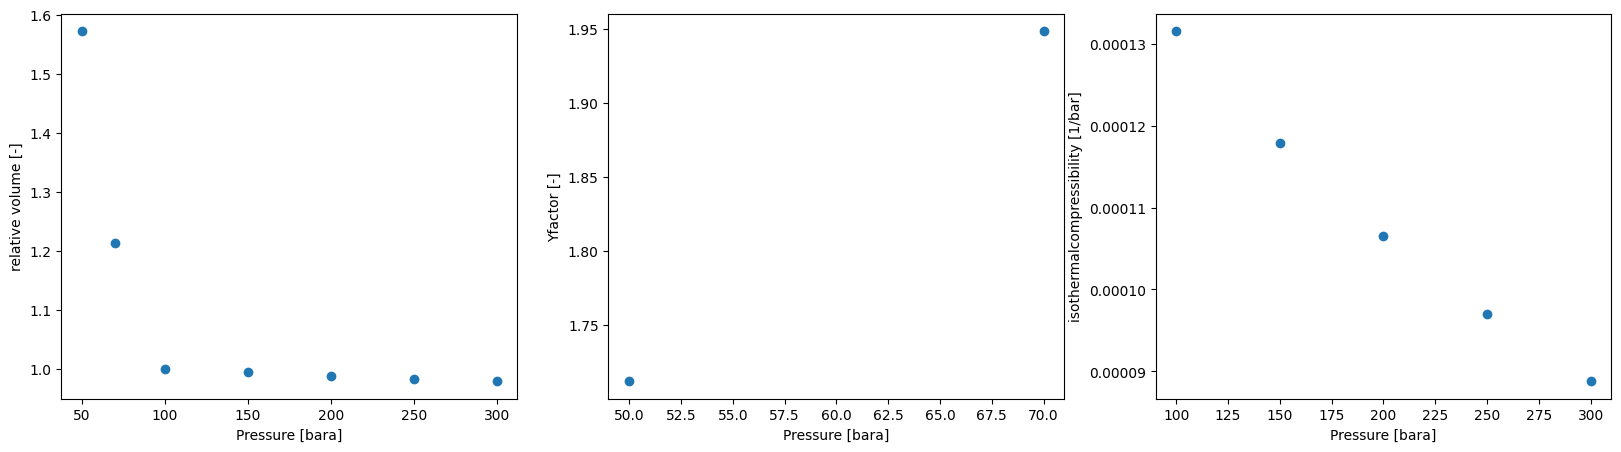

In [24]:
fluid1 = well1.getFluid().clone()

pressure = [300.0, 250.0, 200.0, 150.0, 100.0, 70.0, 50.0]
temperature = [301.0, 301.0, 301.0, 301.0, 301.0, 301.0, 301.0]

relativevolume = []
liquidrelativevolume = []
Zgas =  []
Yfactor = []
isothermalcompressibility = []
satPressure = None
CME(fluid1,pressure,temperature,satPressure,relativevolume, liquidrelativevolume,Zgas,Yfactor,isothermalcompressibility)

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(pressure, relativevolume, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('relative volume [-]')
plt.subplot(132)
plt.plot(pressure, Yfactor, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('Yfactor [-]')
plt.subplot(133)
plt.plot(pressure, isothermalcompressibility, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('isothermalcompressibility [1/bar]')
plt.show()